# Data Integration (Batch correction)

Batch effects are changes in gene expression due to batches arise by different handling conditions such as , library depth, machines, Days, Stress management during extraction, even samples etc. 

But selecting batch and label key is important . according to requirement of keeping batch


general, one can say that Harmony and Seurat consistently perform well for simple batch correction tasks, and scVI, scGen, scANVI, and Scanorama perform well for more complex data integration tasks. 

**Note**

Previous Feature selection used Normalized , scaled data . But for Batch correction it is important to use RawData and find variable genes based on batch (Not on whole data)

It is important to use Rawdata 

*   RawData as adata2 
*   We also use Filted DM data as adata



### Check Batch correction Needed ?

In [ ]:
#@title Load DM reduced filtered data:

adata_QCNFSDM =  sc.read_h5ad("/content/drive/MyDrive/scRNA_using_Python/Objects/sc_QCNFSDM_covid.h5ad")

adata_QCNFSDM

AnnData object with n_obs × n_vars = 3536 × 7650
    obs: 'type', 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_counts', 'S_score', 'G2M_score', 'phase', '_scvi_batch', '_scvi_labels', 'prediction', 'leiden', 'doublet'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std', 'highly_deviant', 'binomial_deviance', 'highly_variable'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'ambient_profile_Gene Expression', 'ambient_profile_all', 'doublet_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'prediction_colors', 'sample_colors', 'tsne', 'type_colors', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'APR_counts', 'ambient_counts', 'counts', 'log1p_norm'
    obs

In [ ]:
#@title Load Raw Data :

adata_raw =  sc.read_h5ad("/content/drive/MyDrive/scRNA_using_Python/Objects/adata_raw_covid.h5ad")

adata_raw.layers["counts"] = adata_raw.X
adata_raw

AnnData object with n_obs × n_vars = 9000 × 33538
    obs: 'type', 'sample', 'batch'
    var: 'gene_ids', 'feature_types', 'genome'
    layers: 'counts'

In [ ]:
adata_raw.obs

,type,sample,batch
AGGGTCCCATGACCCG-1-0,Covid,covid_1,0
TACCCACAGCGGGTTA-1-0,Covid,covid_1,0
CCCAACTTCATATGGC-1-0,Covid,covid_1,0
TCAAGTGTCCGAACGC-1-0,Covid,covid_1,0
ATTCCTAGTGACTGTT-1-0,Covid,covid_1,0
...,...,...,...
CGCATAATCTTACGGA-14-5,Ctrl,ctrl_14,5
GAGGCCTTCTCCTGCA-14-5,Ctrl,ctrl_14,5
CCCTAACAGTTTCTTC-14-5,Ctrl,ctrl_14,5
GGGATGATCAAGCTTG-14-5,Ctrl,ctrl_14,5


In [ ]:
#@title Assign key for batch and label 
label_key = "type"
batch_key = "sample"

In [ ]:
adata_raw.obs[batch_key].value_counts()

covid_1     1500
covid_15    1500
covid_17    1500
ctrl_5      1500
ctrl_13     1500
ctrl_14     1500
Name: sample, dtype: int64

In [ ]:
adata_raw.var["feature_types"].value_counts()

Gene Expression    33538
Name: feature_types, dtype: int64

In [ ]:
#@title filtering to make sure we have no features with zero counts

sc.pp.filter_genes(adata_raw, min_cells=1)
adata_raw

AnnData object with n_obs × n_vars = 9000 × 21830
    obs: 'type', 'sample', 'batch'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    layers: 'counts'

we also need to re-normalise the data. Here we just normalise using global scaling by the total counts per cell.

In [ ]:
#@title simple normalize log1p

adata_raw.X = adata_raw.layers["counts"].copy()
sc.pp.normalize_total(adata_raw)
sc.pp.log1p(adata_raw)
adata_raw.layers["logcounts"] = adata_raw.X.copy()

adata_raw

AnnData object with n_obs × n_vars = 9000 × 21830
    obs: 'type', 'sample', 'batch'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'log1p'
    layers: 'counts', 'logcounts'

In [ ]:

sc.pp.highly_variable_genes(adata_raw)
sc.tl.pca(adata_raw)
sc.pp.neighbors(adata_raw)
sc.tl.umap(adata_raw)
adata_raw

AnnData object with n_obs × n_vars = 9000 × 21830
    obs: 'type', 'sample', 'batch'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'logcounts'
    obsp: 'distances', 'connectivities'

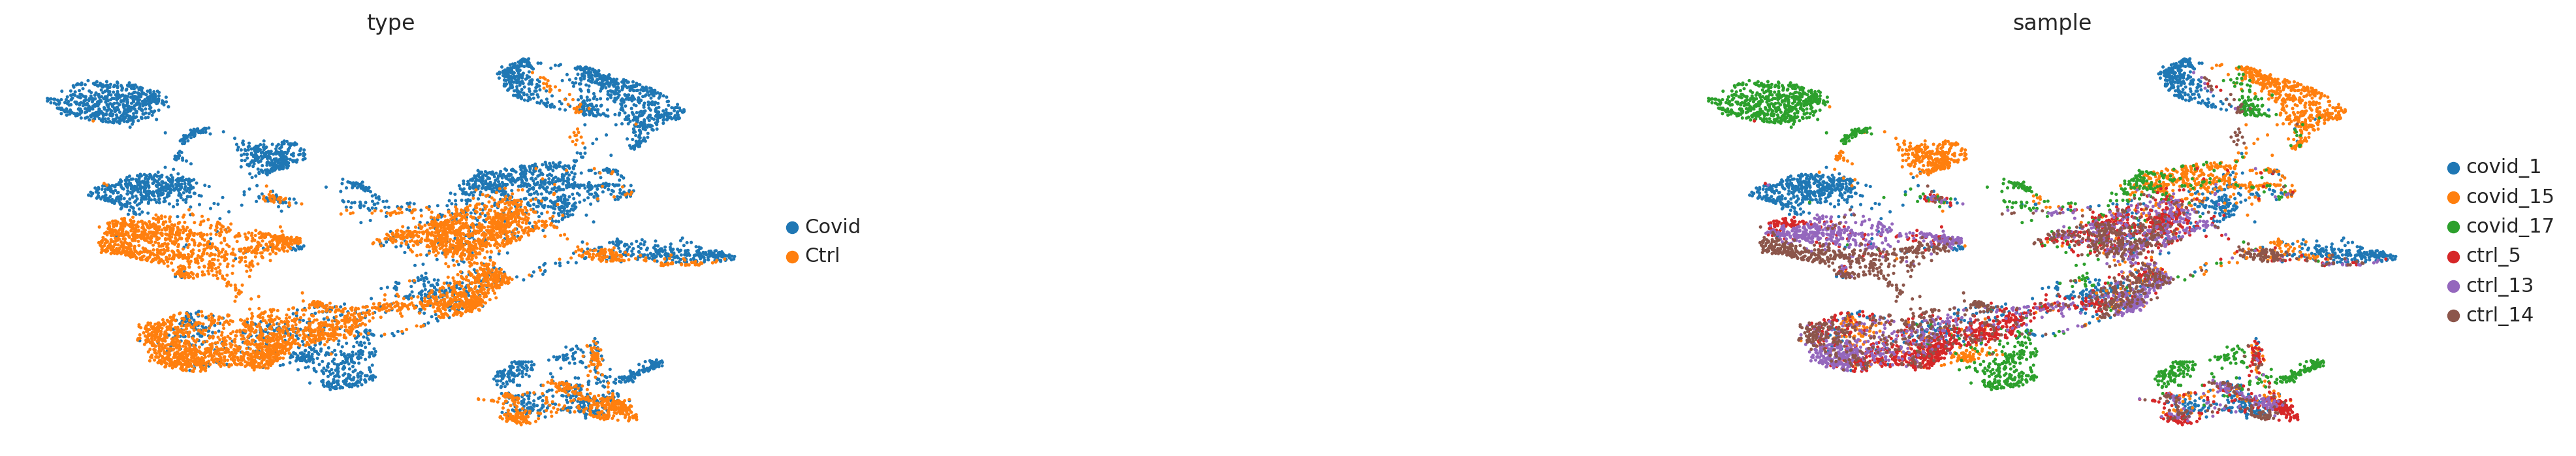

In [ ]:
#@title Batch correction needed ?

adata_raw.uns[batch_key + "_colors"] = [
    "#1b9e77",
    "#d95f02",
    "#7570b3",
]  # Set custom colours for batches
sc.pl.umap(adata_raw, color=[label_key, batch_key], wspace=1)

We need batch correction according to sample batch

### Batch Correction

In [ ]:
#@title Feature selection wrt Batch :

sc.pp.highly_variable_genes(
    adata_raw, n_top_genes=2000, flavor="cell_ranger", batch_key=batch_key
)
adata_raw
adata_raw.var

,gene_ids,feature_types,genome,n_cells,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection
AL627309.1,ENSG00000238009,Gene Expression,GRCh38,25,False,0.001361,0.555600,-0.151289,0,False
AL627309.3,ENSG00000239945,Gene Expression,GRCh38,1,False,0.000041,0.061465,-0.002369,0,False
AL669831.5,ENSG00000237491,Gene Expression,GRCh38,461,False,0.026669,0.737217,-0.089099,0,False
FAM87B,ENSG00000177757,Gene Expression,GRCh38,7,False,0.000366,0.368892,0.569010,1,False
LINC00115,ENSG00000225880,Gene Expression,GRCh38,208,False,0.011747,0.654689,-0.411236,0,False
...,...,...,...,...,...,...,...,...,...,...
AC007325.4,ENSG00000278817,Gene Expression,GRCh38,42,False,0.002123,0.618409,-0.435802,0,False
AL354822.1,ENSG00000278384,Gene Expression,GRCh38,43,False,0.003140,0.822280,1.033842,2,False
AC004556.1,ENSG00000276345,Gene Expression,GRCh38,400,False,0.022188,0.670790,0.646585,1,False
AC233755.1,ENSG00000275063,Gene Expression,GRCh38,4,False,0.000313,0.385842,0.627800,0,False


* highly_variable_nbatches - The number of batches where each gene was found to be highly variable

* highly_variable_intersection - Whether each gene was highly variable in every batch

* highly_variable - Whether each gene was selected as highly variable after combining the results from each batch

0    14794
1     4371
2     1440
3      618
4      286
5      175
6      146
Name: highly_variable_nbatches, dtype: int64

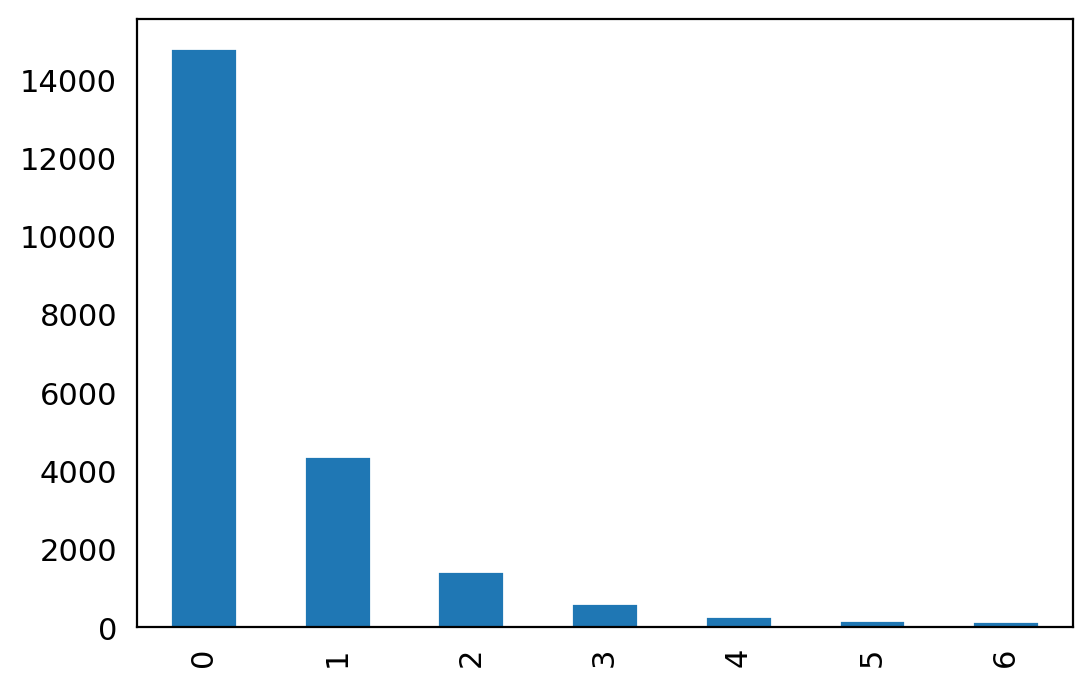

In [ ]:
#@title No of Batches eaach gene

n_batches = adata_raw.var["highly_variable_nbatches"].value_counts()
ax = n_batches.plot(kind="bar")
n_batches


most genes are not highly variable.


In [ ]:
#@title create object to use for Integration

adata_hvg = adata_raw[:, adata_raw.var["highly_variable"]].copy()
adata_hvg

AnnData object with n_obs × n_vars = 9000 × 2000
    obs: 'type', 'sample', 'batch'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'sample_colors', 'type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'logcounts'
    obsp: 'distances', 'connectivities'

#### scvi Data integration (Batch correction)

In [ ]:
adata_scvi = adata_hvg.copy()

adata_scvi

AnnData object with n_obs × n_vars = 9000 × 2000
    obs: 'type', 'sample', 'batch'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'sample_colors', 'type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'logcounts'
    obsp: 'distances', 'connectivities'

prepare our AnnData object. This step stores some information required by scVI such as which expression matrix to use and what the batch key is.

In [ ]:

scvi.model.SCVI.setup_anndata(adata_scvi, layer="counts", batch_key=batch_key)
adata_scvi

AnnData object with n_obs × n_vars = 9000 × 2000
    obs: 'type', 'sample', 'batch', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'sample_colors', 'type_colors', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'logcounts'
    obsp: 'distances', 'connectivities'

In [ ]:
model_scvi = scvi.model.SCVI(adata_scvi)
model_scvi

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Not Trained
Model's adata is minified?: False

In [ ]:
model_scvi.view_anndata_setup()

Anndata setup with scvi-tools version 0.20.3.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': 'sample',
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   6   │
│         n_cells          │ 9000  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 2000  │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                   batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │  covid_1   │          0          │
│                     │  covid_15  │          1          │
│                     │  covid_17  │          2          │
│                     │   ctrl_5   │          3          │
│                     │  ctrl_13   │          4          │
│                     │  ctrl_14   │          5          │
└─────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [ ]:
max_epochs_scvi = np.min([round((20000 / adata_scvi.n_obs) * 400), 400])
max_epochs_scvi

400

In [ ]:
model_scvi.train()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [04:31<00:00,  1.47it/s, loss=429, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [04:31<00:00,  1.48it/s, loss=429, v_num=1]


In [ ]:
adata_scvi.obsm["X_scVI"] = model_scvi.get_latent_representation()

adata_scvi

AnnData object with n_obs × n_vars = 9000 × 2000
    obs: 'type', 'sample', 'batch', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'sample_colors', 'type_colors', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_umap', 'X_scVI'
    varm: 'PCs'
    layers: 'counts', 'logcounts'
    obsp: 'distances', 'connectivities'

In [ ]:
sc.pp.neighbors(adata_scvi, use_rep="X_scVI")
sc.tl.umap(adata_scvi)
adata_scvi

AnnData object with n_obs × n_vars = 9000 × 2000
    obs: 'type', 'sample', 'batch', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'sample_colors', 'type_colors', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_umap', 'X_scVI'
    varm: 'PCs'
    layers: 'counts', 'logcounts'
    obsp: 'distances', 'connectivities'

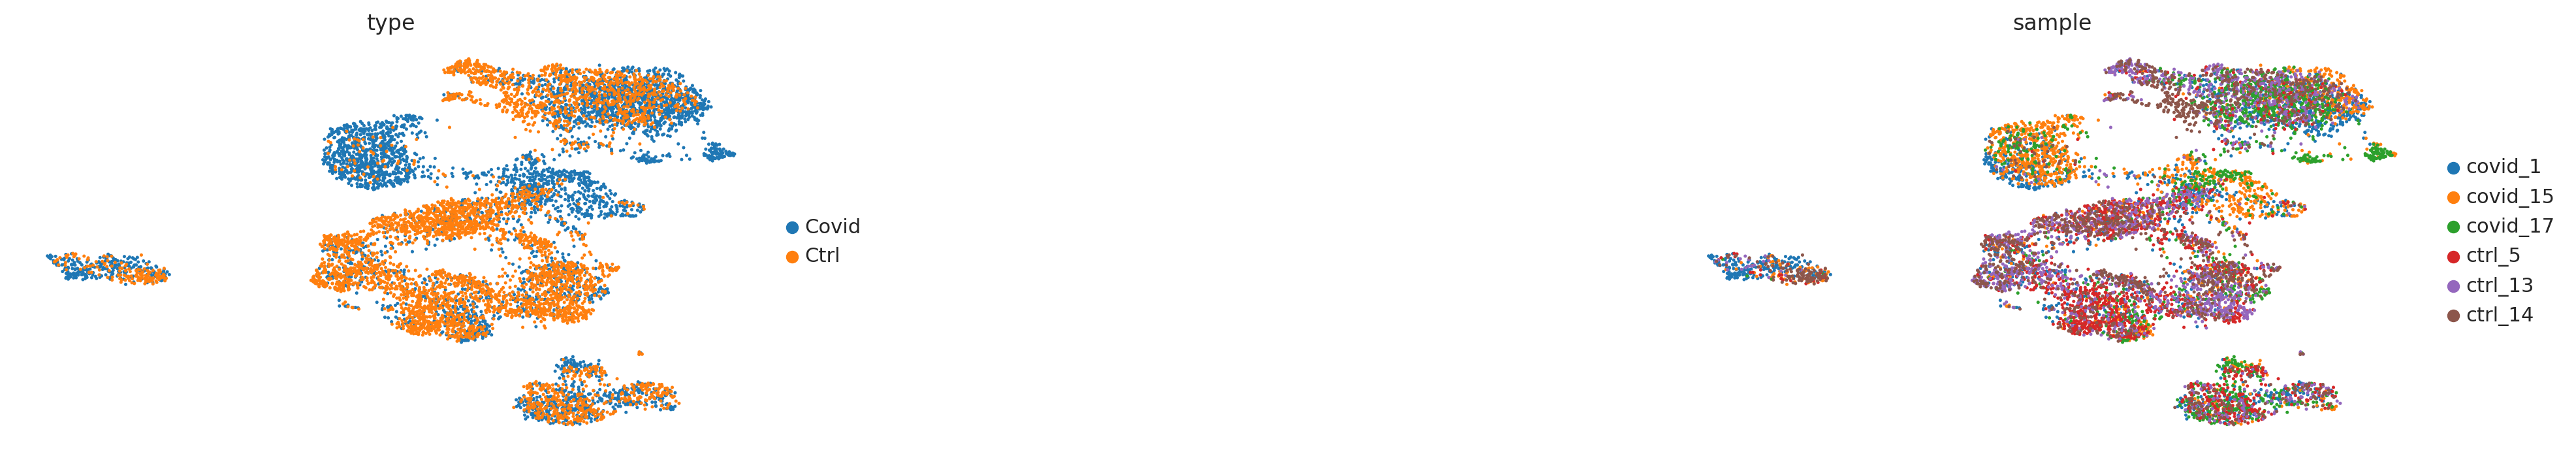

In [ ]:
sc.pl.umap(adata_scvi, color=[label_key, batch_key], wspace=1)

Much Better . But we didn't get corrected metrix

#### BBKNN Integration

An important parameter for BBKNN is the number of neighbors per batch. A suggested heuristic for this is to use 25 if there are more than 100,000 cells or the default of 3 if there are fewer than 100,000.

In [ ]:
neighbors_within_batch = 25 if adata_hvg.n_obs > 100000 else 3
neighbors_within_batch

3

In [ ]:
adata_bbknn = adata_hvg.copy()
adata_bbknn.X = adata_bbknn.layers["logcounts"].copy()
sc.pp.pca(adata_bbknn)

In [ ]:
bbknn.bbknn(
    adata_bbknn, batch_key=batch_key, neighbors_within_batch=neighbors_within_batch
)
adata_bbknn

AnnData object with n_obs × n_vars = 9000 × 2000
    obs: 'type', 'sample', 'batch'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'sample_colors', 'type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'logcounts'
    obsp: 'distances', 'connectivities'

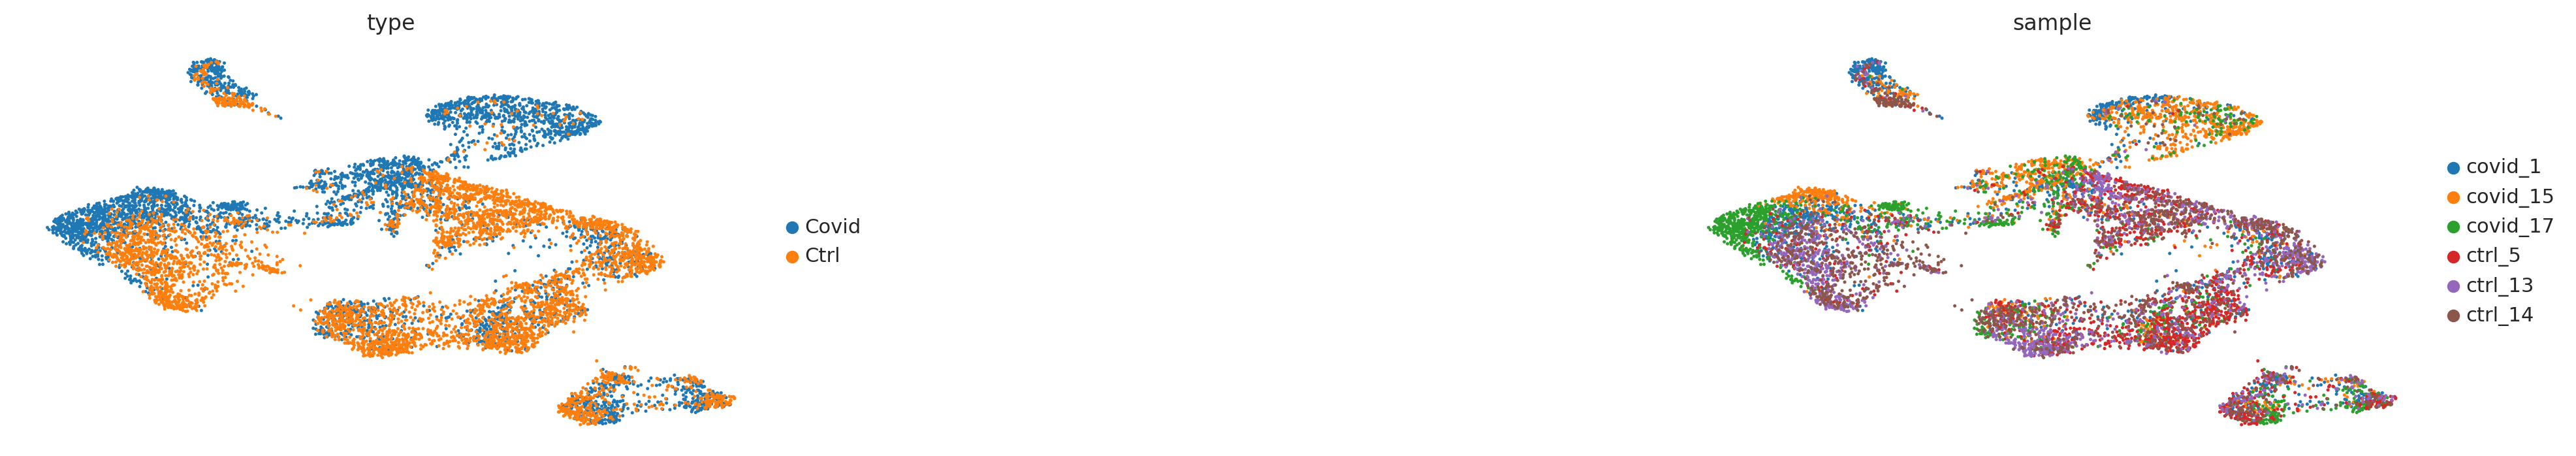

In [ ]:
sc.tl.umap(adata_bbknn)
sc.pl.umap(adata_bbknn, color=[label_key, batch_key], wspace=1)

Much Better

#### scanoama

To run Scanorama, you need to install python-annoy (already included in conda environment) and scanorama with pip. We can run scanorama to get a corrected matrix with the correct function, or to just get the data projected onto a new common dimension with the function integrate. Or both with the correct_scanpy and setting return_dimred=True. For now, run with just integration.

First we need to create individual AnnData objects from each of the datasets.

In [ ]:
adata_scanorama = adata_hvg.copy()

adata_scanorama

AnnData object with n_obs × n_vars = 9000 × 2000
    obs: 'type', 'sample', 'batch'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'sample_colors', 'type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'logcounts'
    obsp: 'distances', 'connectivities'

HES4          3
TNFRSF18      3
TNFRSF4       3
SCNN1D        2
ATAD3B        2
             ..
DIP2A         2
S100B         4
MT-ATP8       5
MT-ND6        5
AC011043.1    3
Name: highly_variable_nbatches, Length: 2000, dtype: int64

In [ ]:
# split per batch into new objects.
batches = adata_scanorama.obs['sample'].cat.categories.tolist()
alldata = {}
for batch in batches:
    alldata[batch] = adata_scanorama[adata_scanorama.obs['sample'] == batch,]

alldata 

{'covid_1': View of AnnData object with n_obs × n_vars = 1500 × 2000
     obs: 'type', 'sample', 'batch'
     var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
     uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'sample_colors', 'type_colors'
     obsm: 'X_pca', 'X_umap'
     varm: 'PCs'
     layers: 'counts', 'logcounts'
     obsp: 'distances', 'connectivities',
 'covid_15': View of AnnData object with n_obs × n_vars = 1500 × 2000
     obs: 'type', 'sample', 'batch'
     var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
     uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'sample_colors', 'type_colors'
     obsm: 'X_pca', 'X_umap'
     varm: 'PCs'
     layers: 'counts', 'logcounts'
     obsp: 'distances', 'connectivities',
 'covid_1

In [ ]:
adata_scanorama.var['highly_variable_nbatches']

var_select = adata_scanorama.var['highly_variable_nbatches'] > 2
var_genes = var_select.index[var_select]
len(var_genes)


1225

In [ ]:
#subset the individual dataset to the variable genes we defined at the beginning
alldata2 = dict()
for ds in alldata.keys():
    print(ds)
    alldata2[ds] = alldata[ds][:,var_genes]

#convert to list of AnnData objects
adatas = list(alldata2.values())

# run scanorama.integrate
scanorama.integrate_scanpy(adatas, dimred = 50)

covid_1
covid_15
covid_17
ctrl_5
ctrl_13
ctrl_14
Found 1225 genes among all datasets
[[0.         0.606      0.34933333 0.53266667 0.38866667 0.25733333]
 [0.         0.         0.63866667 0.478      0.26133333 0.19266667]
 [0.         0.         0.         0.52266667 0.20933333 0.20733333]
 [0.         0.         0.         0.         0.84133333 0.76466667]
 [0.         0.         0.         0.         0.         0.84133333]
 [0.         0.         0.         0.         0.         0.        ]]
Processing datasets (4, 5)
Processing datasets (3, 4)
Processing datasets (3, 5)
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 3)
Processing datasets (2, 3)
Processing datasets (1, 3)
Processing datasets (0, 4)
Processing datasets (0, 2)
Processing datasets (1, 4)
Processing datasets (0, 5)
Processing datasets (2, 4)
Processing datasets (2, 5)
Processing datasets (1, 5)


In [ ]:
#scanorama adds the corrected matrix to adata.obsm in each of the datasets in adatas.

adatas[0].obsm['X_scanorama'].shape

(1500, 50)

In [ ]:
# Get all the integrated matrices.
scanorama_int = [ad.obsm['X_scanorama'] for ad in adatas]

# make into one matrix.
all_s = np.concatenate(scanorama_int)
print(all_s.shape)

# add to the AnnData object, create a new object first
adata_sc = adata_scanorama.copy()
adata_sc.obsm["Scanorama"] = all_s

(9000, 50)


In [ ]:
adata_sc

AnnData object with n_obs × n_vars = 9000 × 2000
    obs: 'type', 'sample', 'batch'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'sample_colors', 'type_colors'
    obsm: 'X_pca', 'X_umap', 'Scanorama'
    varm: 'PCs'
    layers: 'counts', 'logcounts'
    obsp: 'distances', 'connectivities'

In [ ]:
# tsne and umap
sc.pp.neighbors(adata_sc, n_pcs =30, use_rep = "Scanorama")
sc.tl.umap(adata_sc)
sc.tl.tsne(adata_sc, n_pcs = 30, use_rep = "Scanorama")

<Axes: title={'center': 'Scanorama tsne'}, xlabel='UMAP1', ylabel='UMAP2'>

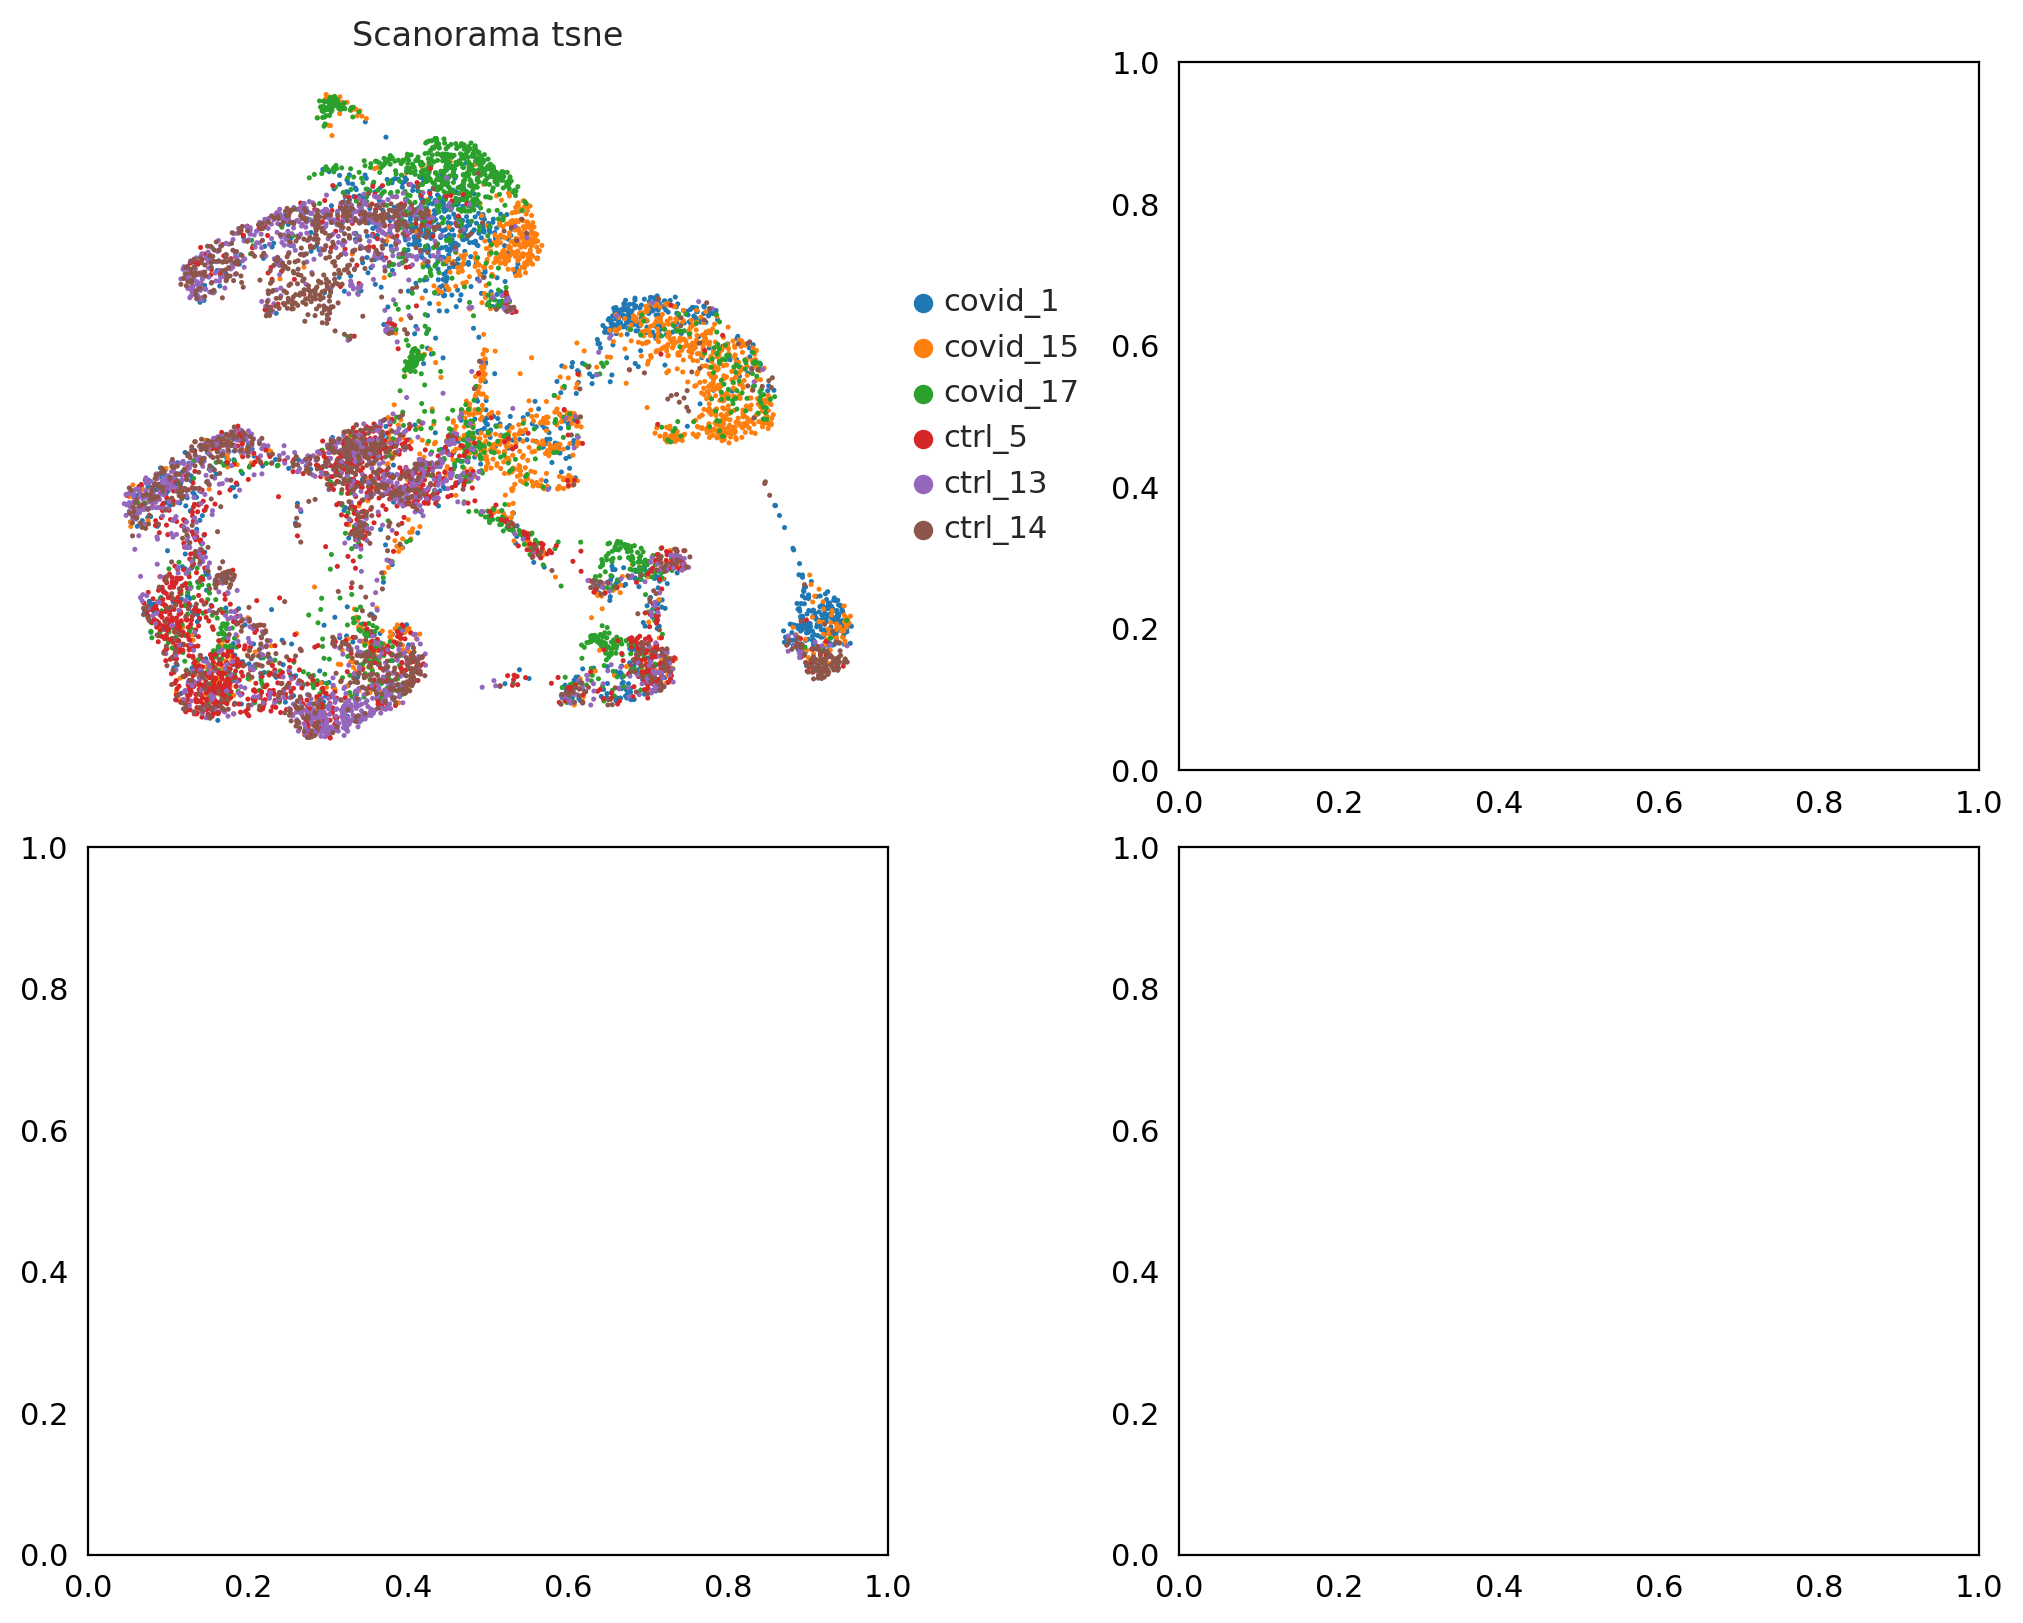

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10,8),constrained_layout=True)

sc.pl.umap(adata_sc, color="sample", title="Scanorama tsne", ax=axs[0,0], show=False)


In [ ]:
#@title save scanroma integrated data to file
save_file = 'Objects/sc_QCNFSDM_scanorama_corrected_covid.h5ad'
adata_sc.write_h5ad(save_file)